# Setup

In [1]:
import collections
import itertools
import wave
from base64 import b64encode
from io import BytesIO
from IPython.display import Audio, HTML, display

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
from chord_progressions.chord import get_note_from_midi_num
from chord_progressions.io.audio import mk_arpeggiated_chord_buffer, combine_buffers, mk_chord_buffer, mk_sin
from chord_progressions.solver import select_voicing
from chord_progressions.type_templates import get_template_from_template_str, TYPE_TEMPLATES
from chord_progressions.utils import is_circular_match
from torch.utils.data import DataLoader
from tqdm import tqdm

from rhythmic_relationships.data import PairDataset

display(HTML("<style>.container { width:100% !important; }</style>"))

SAMPLE_RATE = 44100

def get_type_from_template(template):
    for chord_type in list(TYPE_TEMPLATES):
        if is_circular_match(
            template,
            get_template_from_template_str(TYPE_TEMPLATES[chord_type]),
        ):
            return chord_type

    return ""


def mk_wav(arr):
    """Transform a numpy array to a PCM bytestring
    Adapted from https://github.com/ipython/ipython/blob/main/IPython/lib/display.py#L146
    """
    scaled = arr * 32767
    scaled = scaled.astype("<h").tobytes()

    fp = BytesIO()
    waveobj = wave.open(fp,mode='wb')
    waveobj.setnchannels(1)
    waveobj.setframerate(SAMPLE_RATE)
    waveobj.setsampwidth(2)
    waveobj.setcomptype('NONE','NONE')
    waveobj.writeframes(scaled)
    val = fp.getvalue()
    waveobj.close()

    return val

def get_audio_el(audio):
    wav = mk_wav(audio)
    b64 = b64encode(wav).decode('ascii')
    return f'<audio controls="controls"><source src="data:audio/wav;base64,{b64}" type="audio/wav"/></audio>'

def get_voiced_hits_from_chroma(chroma):
    voiced = []
    for c in chroma:
        voiced.append(select_voicing(c.tolist(), note_range_low=60, note_range_high=72))
    return voiced

def mk_voiced_chroma_buffer(voiced_hits, duration, n_overtones):
    bufs = []

    for hit in voiced_hits:
        pos_dur = duration / len(voiced_hits)

        buf = mk_sin(0, pos_dur, 0).squeeze()
        if hit:
            chord = [get_note_from_midi_num(m) for m in hit]
            buf = mk_chord_buffer(chord, pos_dur, n_overtones)
        bufs.append(buf)

    return np.concatenate(bufs, axis=0).reshape(-1, 1)

# Hits
## Create bigrams

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1651/1651 [00:05<00:00, 277.74it/s]


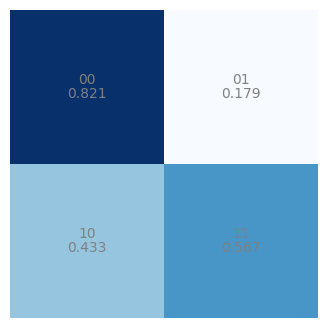

In [2]:
dataset_config = {
    "dataset_name": "babyslakh_20_1bar_4res",
    "part_1": 'Bass',
    "part_2": 'Piano',
    "repr_1": "hits",
    "repr_2": "hits",
}

data = PairDataset(**dataset_config)
loader = DataLoader(data, batch_size=1)

n = 2
N = torch.zeros((n, n), dtype=torch.int32)

for x, y in tqdm(loader):
    # Binarize the hits
    x = (x > 0).to(torch.int32)
    y = (y > 0).to(torch.int32)
    for h1, h2 in zip(x.flatten(), y.flatten()):
        ix1 = h1.item()
        ix2 = h2.item()
        N[ix1, ix2] += 1

# Adding a count of 1 to ensure there are no 0s in our probability matrix P
# This is called model smoothing
P = (N+1).float()
P /= P.sum(1, keepdims=True)

plt.figure(figsize=(4,4))
plt.imshow(P, cmap='Blues')
for i in range(n):
    for j in range(n):
        chstr = str(i) + str(j)
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha="center", va="top", color='gray')
plt.axis('off');

## Sample hits

In [3]:
g = torch.Generator().manual_seed(15987348311)

n_samples = 3
audio_duration = 3  # seconds
n_overtones = 0

input_hits = [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
inbuff = mk_arpeggiated_chord_buffer(["C4"], audio_duration, [input_hits], n_overtones)
inhitstr = "".join(map(str, input_hits))

buffs = {}
rand_buffs = {}
for i in range(n_samples):
    out = []
    rand_out = []
    for el in input_hits:
        p = P[el]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(ix)

        rand_p = torch.ones(n) / n  # uniform distribution
        rand_ix = torch.multinomial(
            rand_p, num_samples=1, replacement=True, generator=g
        ).item()
        rand_out.append(rand_ix)

    outbuff = mk_arpeggiated_chord_buffer(["G4"], audio_duration, [out], n_overtones)
    buffs["".join(map(str, out))] = combine_buffers([inbuff, outbuff])

    rand_hbuff = mk_arpeggiated_chord_buffer(
        ["G4"], audio_duration, [rand_out], n_overtones
    )
    rand_buffs["".join(map(str, rand_out))] = combine_buffers([inbuff, rand_hbuff])

html = (
    f'Input {dataset_config["part_1"]}</br>{get_audio_el(inbuff)}{inhitstr}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from bigram distribution'
    + "".join([f"</br>{get_audio_el(v)} {k}" for k, v in buffs.items()])
    + "</br></br>Samples from uniform distribution"
    + "".join([f"</br>{get_audio_el(v)} {k}" for k, v in rand_buffs.items()])
)

HTML(html)

## Compute loss

In [4]:
# The goal is to maximize the likelihood of the data w.r.t. the model parameters
# This is equivalent to maximizing the log likelihood (because log is monotonic)
# which is equivalent to minimizing the negative log likelihood
# which is equivalent to minimizing the average negative log likelihood
# log(a*b*c) = log(a) + log(b) + log(c)

log_likelihood = 0.0
nixs = 0
for x, y in tqdm(loader):
    # Binarize the hits
    x = (x > 0).to(torch.int32)
    y = (y > 0).to(torch.int32)
    for h1, h2 in zip(x.flatten(), y.flatten()):
        ix1 = h1.item()
        ix2 = h2.item()
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        nixs += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/nixs}') # Average loss likelihood

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1651/1651 [00:05<00:00, 284.49it/s]

log_likelihood=tensor(-13905.8047)
nll=tensor(13905.8047)
0.526416003704071


# Chroma

## Creating chroma bigrams

Specifically we use binary chromas, which are (N, 12) matrices of pitch class activations, where N is the number of timesteps and the values show the presence or absence of the pitch class.

We could use binary pitch class strings of length 12 (e.g. `100100100100`) as tokens. That would give us a vocab size of 2**12 = 4096 (e.g. `perms = [''.join(map(str, i)) for i in itertools.product([0, 1], repeat=12)]` ). With the 36752 pairs in `babyslakh_20` that would give us a data : vocab ratio of ~9. Makemore has a 8500x data : vocab ratio (228146 pairs : vocab 27). To get a similar 8500x ratio we need ~35M pairs. Assuming the `babyslakh_20` average of ~1.8k pairs per file, we'd need ~19k files. `lmd_clean` is 17k files which is close, but it takes a long time to process and work with.

We opt to instead shrink the vocab size by labeling the pitch class strings with [chord types](https://github.com/p3zo/chord-progressions/blob/main/chord_progressions/type_templates.py). That gives a vocab size of 193 (191 templates + 1 silence token + 1 out-of-vocab token). A vocab size of 193 wants ~1.7M pairs for the same ratio as makemore, which should be around 1k files. So we use `lmd_clean_1000`.

In [5]:
dataset_config = {
    "dataset_name": "babyslakh_20_1bar_4res",
    "part_1": 'Guitar',
    "part_2": 'Piano',
    "repr_1": "chroma",
    "repr_2": "chroma",
}

data = PairDataset(**dataset_config)
loader = DataLoader(data, batch_size=1)

TYPE_TEMPLATES.update({'silence': '000000000000'})
vocab_size = len(TYPE_TEMPLATES)
print(f'Vocab size: {vocab_size}')

N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

inv_type_templates = {v: k for k, v in TYPE_TEMPLATES.items()}
stoi = {s:i for i,s in enumerate(inv_type_templates)}
itos = {i:s for s,i in stoi.items()}
itos[0] = '000000000000' # Use silence for out-of-vocab

for x, y in tqdm(loader):
    # Binarize the chromas
    x = (x > 1).to(torch.int32)
    y = (y > 1).to(torch.int32)
    for h1, h2 in zip(x, y):
        for xrow, yrow in zip(h1, h2):
            xtype = get_type_from_template(xrow.tolist())
            ytype =  get_type_from_template(yrow.tolist())
            x_template_str = TYPE_TEMPLATES[xtype]
            y_template_str = TYPE_TEMPLATES[ytype]
            ixx = stoi[x_template_str]
            ixy = stoi[y_template_str]
            N[ixx, ixy] += 1

P = (N+1).float()
P /= P.sum(1, keepdims=True)

print(N.float().min(), N.float().max())
print(P.min(), P.max())
print(N.sum())

Vocab size: 193


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:18<00:00, 75.59it/s]

tensor(0.) tensor(6269.)
tensor(7.7119e-05) tensor(0.4835)
tensor(22592)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 1441.68it/s]


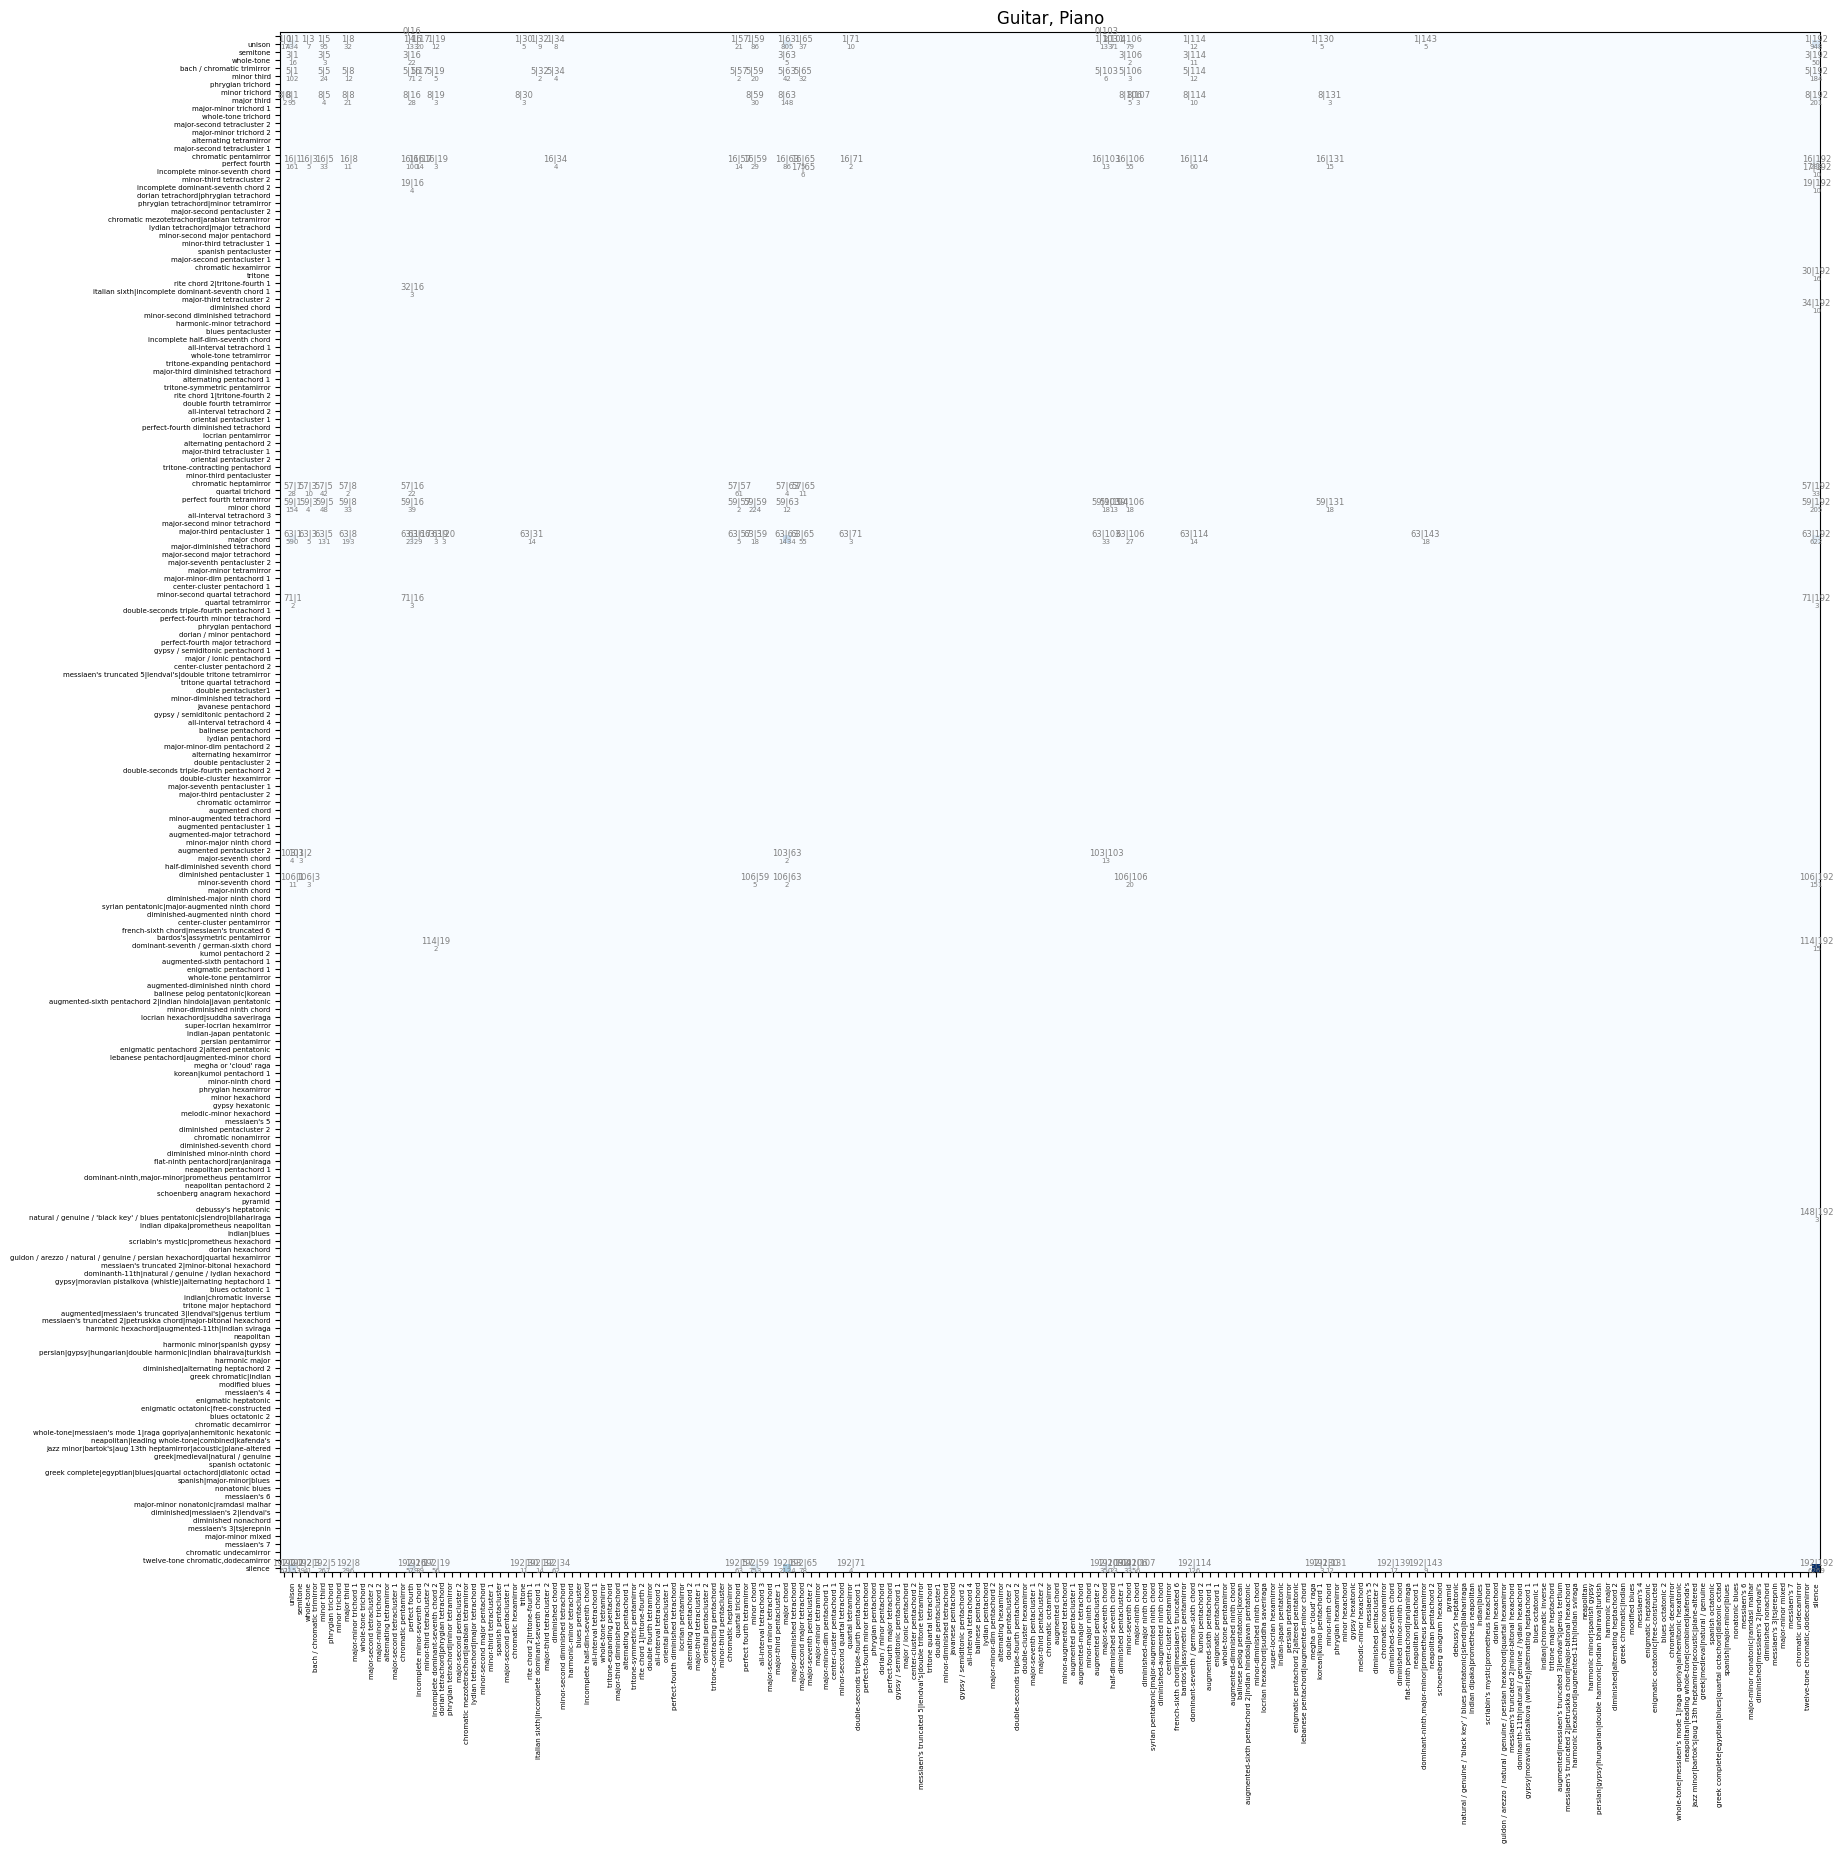

In [6]:
title = f"{dataset_config['part_1']}, {dataset_config['part_2']}"
plt.figure(figsize=(20,20))
plt.imshow(N, cmap='Blues');
plt.title(title)
plt.xticks(range(vocab_size), labels=list(TYPE_TEMPLATES), rotation=90, fontsize=5);
plt.yticks(range(vocab_size), labels=list(TYPE_TEMPLATES), fontsize=5);
for i in tqdm(range(vocab_size)):
    for j in range(vocab_size):
#         chstr = '_'.join([inv_type_templates[itos[i]], inv_type_templates[itos[j]]])
        chstr = '|'.join([str(i), str(j)])
        val = N[i, j].item()
        if val > 1:
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray', fontsize=6)
            plt.text(j, i, round(val, 2), ha="center", va="top", color='gray', fontsize=5)

In [7]:
print(dataset_config['part_1'], dataset_config['part_2'])
for ix, i in enumerate(TYPE_TEMPLATES):
    v = N[ix].sum().item()
    if v > 0:
        print(v, i)

Guitar Piano
7 
2986 unison
113 whole-tone
524 minor third
557 major third
900 perfect fourth
18 incomplete minor-seventh chord
15 incomplete dominant-seventh chord 2
16 tritone
6 italian sixth|incomplete dominant-seventh chord 1
10 diminished chord
214 quartal trichord
790 minor chord
3409 major chord
8 quartal tetramirror
2 perfect-fourth minor tetrachord
24 major-seventh chord
195 minor-seventh chord
21 dominant-seventh / german-sixth chord
3 natural / genuine / 'black key' / blues pentatonic|slendro|bilahariraga
12774 silence


## Sampling chroma

Using chord types as our vocabulary has the added benefit of being able to use can use `chord_progressions.solver` to find voicings for templates that we sample.

In [8]:
g = torch.Generator().manual_seed(15987348311)

n_samples = 3
duration = 3  # seconds

input_chord_types = [
    "major chord",
    "silence",
    "silence",
    "silence",
    "unison",
    "minor chord",
    "silence",
    "silence",
    "major chord",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
]
in_chroma = np.array([list(map(int, TYPE_TEMPLATES[i])) for i in input_chord_types])
in_voiced_hits = get_voiced_hits_from_chroma(in_chroma)
in_buff = mk_voiced_chroma_buffer(in_voiced_hits, duration=duration, n_overtones=1)
in_hits = (in_chroma.sum(axis=1) > 0).astype(np.int8)

buffs = collections.defaultdict(list)
rand_buffs = collections.defaultdict(list)
for i in range(n_samples):
    rand_chroma = []
    out_chroma = []
    for t in in_chroma:
        tix = stoi[TYPE_TEMPLATES[get_type_from_template(t)]]
        p = P[tix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        pchromavec = list(map(int, itos[ix]))
        out_chroma.append(pchromavec)

        rand_p = torch.ones(vocab_size) / vocab_size  # uniform distribution
        rand_ix = torch.multinomial(rand_p, num_samples=1, replacement=True, generator=g).item()
        # For now, map out-of-vocabulary token to silence
        if rand_ix == 0:
            rand_ix = 192
        rand_pchromavec = list(map(int, itos[rand_ix]))
        rand_chroma.append(rand_pchromavec)

    out_chroma = np.array(out_chroma)
    out_hits = (out_chroma.sum(axis=1) > 0).astype(np.int8)
    out_voiced_hits = get_voiced_hits_from_chroma(out_chroma)
    out_buff = mk_voiced_chroma_buffer(out_voiced_hits, duration=duration, n_overtones=4)
    buffs["".join(map(str, out_hits))].append([out_buff, combine_buffers([in_buff, out_buff])])

    rand_chroma = np.array(rand_chroma)
    rand_hits = (rand_chroma.sum(axis=1) > 0).astype(np.int8)
    rand_voiced_hits = get_voiced_hits_from_chroma(rand_chroma)
    rand_buff = mk_voiced_chroma_buffer(rand_voiced_hits, duration=duration, n_overtones=4)
    rand_buffs["".join(map(str, rand_hits))].append([rand_buff, combine_buffers([in_buff, rand_buff])])

html = (
    f'Input {dataset_config["part_1"]}</br>{"".join(map(str, in_hits))}</br>{get_audio_el(in_buff)}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from bigram distribution'
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in buffs.items()])
    + "</br></br>Samples from uniform distribution"
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in rand_buffs.items()])
)

HTML(html)

## Compute loss

In [9]:
log_likelihood = 0.0
nixs = 0
for x, y in tqdm(loader):
    # Binarize the chromas
    x = (x > 1).to(torch.int32)
    y = (y > 1).to(torch.int32)
    for h1, h2 in zip(x, y):
        for xrow, yrow in zip(h1, h2):
            xtype = get_type_from_template(xrow.tolist())
            ytype =  get_type_from_template(yrow.tolist())
            x_template_str = TYPE_TEMPLATES[xtype]
            y_template_str = TYPE_TEMPLATES[ytype]
            ixx = stoi[x_template_str]
            ixy = stoi[y_template_str]

            prob = P[ixx, ixy]
            logprob = torch.log(prob)
            log_likelihood += logprob
            nixs += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/nixs}') # Average loss likelihood
# The lower this number is, the better the model is because it means it is assigning
# high probabilities to the actual chord type pair in all the bigrams in our training set

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:18<00:00, 74.94it/s]

log_likelihood=tensor(-43342.3359)
nll=tensor(43342.3359)
1.9184815883636475


# Recast the problem into a neural network framework

Still using chroma bigrams

In [10]:
# Create the training set of bigrams
xs, ys = [], []

for x, y in tqdm(loader):
    # Binarize the chromas
    x = (x > 1).to(torch.int32)
    y = (y > 1).to(torch.int32)
    for h1, h2 in zip(x, y):
        for xrow, yrow in zip(h1, h2):
            xtype = get_type_from_template(xrow.tolist())
            ytype =  get_type_from_template(yrow.tolist())
            x_template_str = TYPE_TEMPLATES[xtype]
            y_template_str = TYPE_TEMPLATES[ytype]
            ixx = stoi[x_template_str]
            ixy = stoi[y_template_str]
            xs.append(ixx)
            ys.append(ixy)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
n_examples = xs.nelement()
print(f'Number of examples {n_examples}')

# Initialize the "network" with a single linear layer of randomly initialized weights
g = torch.Generator().manual_seed(15987348311)
W = torch.randn((vocab_size, vocab_size), generator=g, requires_grad=True)

# One-hot encode the input to the network
xenc = F.one_hot(xs, num_classes=vocab_size).float()
print(xenc.shape, W.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1412/1412 [00:18<00:00, 75.88it/s]

Number of examples 22592
torch.Size([22592, 193]) torch.Size([193, 193])


In [11]:
for k in range(1000):
    # Forward pass
    # Predict log-counts
    logits = xenc @ W

    # Softmax
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for each chord type

    # Compute avg negative log likelihood
    loss = -probs[torch.arange(n_examples), ys].log().mean() + 0.01 * (W**2).mean()
    if k % 100 == 0:
        print(loss.item())

    # Backward pass
    W.grad = None # set the gradient to 0
    loss.backward()

    # W.grad has the same shape as W
    # Each element of the gradient tells us the influence of that weight on the loss function
    # Update the weights based on the gradient
    W.data += -10 * W.grad

5.652843475341797
2.1005241870880127
2.0001955032348633
1.9586706161499023
1.9358361959457397
1.9209519624710083
1.9100964069366455
1.9017583131790161
1.8952518701553345
1.8901560306549072


In [12]:
P[10][10], W.exp()[10][10]

(tensor(0.0052), tensor(0.4362, grad_fn=<SelectBackward0>))

In [13]:
# Finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(15987348311)

n_samples = 3
duration = 3  # seconds

input_chord_types = [
    "major chord",
    "silence",
    "silence",
    "silence",
    "unison",
    "minor chord",
    "silence",
    "silence",
    "major chord",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
    "silence",
]
in_chroma = np.array([list(map(int, TYPE_TEMPLATES[i])) for i in input_chord_types])
in_voiced_hits = get_voiced_hits_from_chroma(in_chroma)
in_buff = mk_voiced_chroma_buffer(in_voiced_hits, duration=duration, n_overtones=1)
in_hits = (in_chroma.sum(axis=1) > 0).astype(np.int8)

buffs = collections.defaultdict(list)
for i in range(n_samples):
    out_chroma = []
    for t in in_chroma:
        tix = stoi[TYPE_TEMPLATES[get_type_from_template(t)]]
        # ----
        # BEFORE:
        # p = P[tix]
        # ----
        # NOW
        xenc = F.one_hot(torch.tensor([tix]), num_classes=vocab_size).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        pchromavec = list(map(int, itos[ix]))
        out_chroma.append(pchromavec)

    out_chroma = np.array(out_chroma)
    out_hits = (out_chroma.sum(axis=1) > 0).astype(np.int8)
    out_voiced_hits = get_voiced_hits_from_chroma(out_chroma)
    out_buff = mk_voiced_chroma_buffer(out_voiced_hits, duration=duration, n_overtones=4)
    buffs["".join(map(str, out_hits))].append([out_buff, combine_buffers([in_buff, out_buff])])

html = (
    f'Input {dataset_config["part_1"]}</br>{"".join(map(str, in_hits))}</br>{get_audio_el(in_buff)}'
    + f'</br></br>Predicted {dataset_config["part_2"]}</br></br>Samples from learned distribution'
    + "".join([f"</br>{k}</br>{get_audio_el(v[0][0])}predicted</br>{get_audio_el(v[0][1])}combined" for k, v in buffs.items()])
)

HTML(html)